<a href="https://colab.research.google.com/github/plaban1981/DEEP-LEARNING-/blob/master/Neural_networks_for_your_groceries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction 
Instacart is an on-demand grocery delivery app that allows a user to browse and pick out products they want from a virtual catalog from local grocery stores. A personal shopper receives your order, and then does the in-store shopping and delivery for you. To improve the grocery shopping experience, it would be advantageous if Instacart could predict what products a customer will purchase again. This will allow Instacart to generate personalized experiences for every user, helping them easily rediscover their favorite products. Creating an efficient and convenient shopping experience for customers will help more users adopt this new format of grocery shopping.

# Problem statement:
    
To build a neural network in Keras to predict whether a user will reorder an item.

# Data

It contains over 3 million orders from more than 200,000 users, and there is data about the user's orders, the sequence of products purchased, and when it was ordered.

#### Link : https://www.instacart.com/datasets/grocery-shopping-2017

The dataset comes in a set of 6 csv files:

* 3 files contain data about the product, aisle and department.

* 3 files contain data with prior purchase history, recent purchase history and complete order history.

# Referrrences :-

    https://towardsdatascience.com/neural-networks-for-your-groceries-f0a643eb411

    https://nbviewer.jupyter.org/github/stevhliu/instacart-neural-network/blob/master/instacart%20neural%20network.ipynb


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# Import Libraries

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore')

%matplotlib inline
plt.style.use('seaborn')



In [0]:
# load the data
p = pd.read_csv('drive/My Drive/instacart/products.csv')
d = pd.read_csv('drive/My Drive/instacart/departments.csv')
a = pd.read_csv('drive/My Drive/instacart/aisles.csv')

In [4]:
p.columns

Index(['product_id', 'product_name', 'aisle_id', 'department_id'], dtype='object')

In [5]:
d.columns

Index(['department_id', 'department'], dtype='object')

In [6]:
a.columns

Index(['aisle_id', 'aisle'], dtype='object')

In [7]:
# right join to merge the dataframes on department and aisle id
catalog = pd.merge(p,d,how='right',on='department_id')
catalog = pd.merge(catalog,a,how='right',on='aisle_id')
catalog.head()

,product_id,product_name,aisle_id,department_id,department,aisle
0,1,Chocolate Sandwich Cookies,61,19,snacks,cookies cakes
1,78,Nutter Butter Cookie Bites Go-Pak,61,19,snacks,cookies cakes
2,102,Danish Butter Cookies,61,19,snacks,cookies cakes
3,172,Gluten Free All Natural Chocolate Chip Cookies,61,19,snacks,cookies cakes
4,285,Mini Nilla Wafers Munch Pack,61,19,snacks,cookies cakes


# Create a dataframe containing prior purchase history, and join with the catalog data, so we know what users are buying

In [0]:
# create dataframe with prior purchasing history
orders = pd.read_csv('drive/My Drive/instacart/orders.csv')
X = pd.read_csv('drive/My Drive/instacart/order_products__prior.csv')

In [9]:
orders.columns

Index(['order_id', 'user_id', 'eval_set', 'order_number', 'order_dow',
       'order_hour_of_day', 'days_since_prior_order'],
      dtype='object')

In [10]:
X.columns

Index(['order_id', 'product_id', 'add_to_cart_order', 'reordered'], dtype='object')

In [11]:
X = pd.merge(X,orders,how='left',on='order_id')
X = pd.merge(X,catalog,how='left',on = 'product_id')
X.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,department,aisle
0,2,33120,1,1,202279,prior,3,5,9,8.0,Organic Egg Whites,86,16,dairy eggs,eggs
1,2,28985,2,1,202279,prior,3,5,9,8.0,Michigan Organic Kale,83,4,produce,fresh vegetables
2,2,9327,3,0,202279,prior,3,5,9,8.0,Garlic Powder,104,13,pantry,spices seasonings
3,2,45918,4,1,202279,prior,3,5,9,8.0,Coconut Butter,19,13,pantry,oils vinegars
4,2,30035,5,0,202279,prior,3,5,9,8.0,Natural Sweetener,17,13,pantry,baking ingredients


*Because this dataset consumes a tremendous amount of memory (3.9GB+), downsample the dataset to lighten the computational load. Once we get a working model, we can come back and use the full dataset.*

In [0]:
# downsample the original datasets to 1 million records
X = X.iloc[0:1000000,]

In [13]:
X.shape

(1000000, 15)

**Check for missing Data if any**

In [16]:
X.isnull().sum()[X.isnull().sum() !=0]

days_since_prior_order    63884
dtype: int64

*There is some missing data here as a result of new users who have just signed up, and started using the service.

As a result, Instacart does not have any previous record of these users making a prior purchase, leaving us with a null value. 

Replace these null values with 0.*

In [0]:
# replace null values with 0
X.replace(np.NaN, 0, inplace=True)

In [18]:
X.isnull().sum()[X.isnull().sum() !=0]

Series([], dtype: int64)

**datatypes**

In [19]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 0 to 999999
Data columns (total 15 columns):
order_id                  1000000 non-null int64
product_id                1000000 non-null int64
add_to_cart_order         1000000 non-null int64
reordered                 1000000 non-null int64
user_id                   1000000 non-null int64
eval_set                  1000000 non-null object
order_number              1000000 non-null int64
order_dow                 1000000 non-null int64
order_hour_of_day         1000000 non-null int64
days_since_prior_order    1000000 non-null float64
product_name              1000000 non-null object
aisle_id                  1000000 non-null int64
department_id             1000000 non-null int64
department                1000000 non-null object
aisle                     1000000 non-null object
dtypes: float64(1), int64(10), object(4)
memory usage: 122.1+ MB


Quite a few variables are numerical when they should be categorical.

For example, while **aisle_id** is a number, it is really a categorical variable, because each aisle is discrete. Also, convert days_since_prior_order to an integer because it doesn't make sense for it to be a float (i.e. there aren't 8.675 days). Finally, drop user_id/eval_set because they have no predictive value, and are just unique identifiers.

In [0]:
# convert days_since_prior_order to integer first
X['days_since_prior_order'] = X['days_since_prior_order'].astype(int)

In [0]:
obj_col = []
for i in X.columns:
  if X[i].dtypes == 'object':
    obj_col.append(i)

In [23]:
obj_col

['eval_set', 'product_name', 'department', 'aisle']

In [0]:
# convert integers to categorical variables
int_to_cat = ['product_id', 'reordered', 'order_dow', 
              'order_hour_of_day', 'aisle_id', 'department_id',
              'days_since_prior_order']

for var in int_to_cat:
    X[var] = X[var].astype('str')

In [25]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 0 to 999999
Data columns (total 15 columns):
order_id                  1000000 non-null int64
product_id                1000000 non-null object
add_to_cart_order         1000000 non-null int64
reordered                 1000000 non-null object
user_id                   1000000 non-null int64
eval_set                  1000000 non-null object
order_number              1000000 non-null int64
order_dow                 1000000 non-null object
order_hour_of_day         1000000 non-null object
days_since_prior_order    1000000 non-null object
product_name              1000000 non-null object
aisle_id                  1000000 non-null object
department_id             1000000 non-null object
department                1000000 non-null object
aisle                     1000000 non-null object
dtypes: int64(4), object(11)
memory usage: 122.1+ MB


In [0]:
# drop unnecessary variables
X.drop(['user_id', 'eval_set'], axis=1, inplace=True)

In [27]:
X.head()

,order_id,product_id,add_to_cart_order,reordered,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,department,aisle
0,2,33120,1,1,3,5,9,8,Organic Egg Whites,86,16,dairy eggs,eggs
1,2,28985,2,1,3,5,9,8,Michigan Organic Kale,83,4,produce,fresh vegetables
2,2,9327,3,0,3,5,9,8,Garlic Powder,104,13,pantry,spices seasonings
3,2,45918,4,1,3,5,9,8,Coconut Butter,19,13,pantry,oils vinegars
4,2,30035,5,0,3,5,9,8,Natural Sweetener,17,13,pantry,baking ingredients


**Visualizing the catalog**

In [29]:
!pip install squarify

In [0]:
# import squarify to create a treemap
import squarify
import matplotlib


In [0]:
# get number of products in each department
x1 = (catalog.groupby(['department']).count().reset_index())

In [33]:
x1.head()

,department,product_id,product_name,aisle_id,department_id,aisle
0,alcohol,1054,1054,1054,1054,1054
1,babies,1081,1081,1081,1081,1081
2,bakery,1516,1516,1516,1516,1516
3,beverages,4365,4365,4365,4365,4365
4,breakfast,1115,1115,1115,1115,1115


In [34]:
# generate labels with number of products in each department
labels = x1.apply(lambda x: str(x[0]) + '\n (' + str(x[1]) + ')', axis=1)
labels.head()

0      alcohol\n (1054)
1       babies\n (1081)
2       bakery\n (1516)
3    beverages\n (4365)
4    breakfast\n (1115)
dtype: object

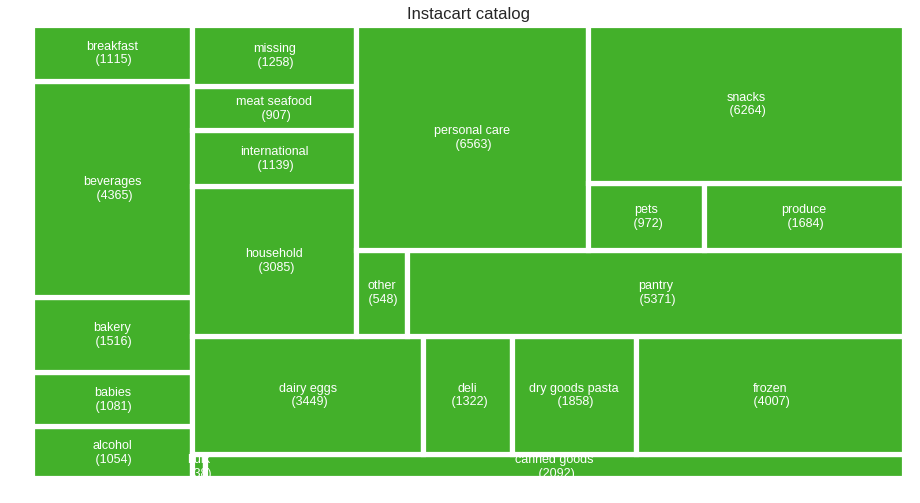

In [38]:
# create plot
plt.figure(figsize=(15, 8), dpi=75)

# plot data and add padding around squares for better visualization
squarify.plot(label=labels, sizes=x1.product_id, color='#43B02A',
              text_kwargs={'fontsize':'large', 'color':'white'},
              bar_kwargs={'edgecolor': 'w', 'linewidth':5})
plt.title('Instacart catalog', fontsize=16)

# remove axes and display plot
plt.axis('off')
plt.show()

The snack, personal care, and pantry departments contain the most products, and users probably tend to purchase more frequently from these departments. This provides some intuition about what types of items users are likely to reorder: everyday items that are rapidly consumed. Having a diverse selection of items in these departments ensure consumers will find a brand they like, and will buy time and time again.

However, the quantity of items in each department is not an indicator of how likely users will purchase from that department. For example, the meat and seafood department can only offer a certain number of products. There are a finite number of cuts of meat, and types of seafood at any given time during the year. Additionally, seafood availability is heavily dependent on geography, and access to distributors. Likewise, produce is also impacted by seasonal availability. In contrast, there could be a near infinite variety of snacks or personal care products (i.e. many different types of deodorant scent).

Interestingly, there is also a department of missing items, where the item is not available in-store. This is bad for shoppers who are looking for the item in-store but cannot find them, leading to wasted time, and delayed delivery. Customers aren't happy because they don't get what they want, and the suggested replacement item may not be satisfactory, leading to frustration. Finally, retail partners miss an opportunity to generate revenue on the item.

** Department purchasing traffic**

Understanding time-based customer behavior is useful for generating personalized suggestions. Suppose most users order from the meat and seafood department in the evening so that it is ready for dinner. Instacart can then send a notification to users, whether it is to remind them to order their usual tri-tip, or suggest them to try the Chilean sea bass for the first time tonight.

In [39]:
# create dataframe for number of orders per hour of day for each department
x2 = (X.groupby(['department', 'order_hour_of_day']).count().reset_index())
x2.head()

,department,order_hour_of_day,order_id,product_id,add_to_cart_order,reordered,order_number,order_dow,days_since_prior_order,product_name,aisle_id,department_id,aisle
0,alcohol,0,13,13,13,13,13,13,13,13,13,13,13
1,alcohol,1,7,7,7,7,7,7,7,7,7,7,7
2,alcohol,10,407,407,407,407,407,407,407,407,407,407,407
3,alcohol,11,464,464,464,464,464,464,464,464,464,464,464
4,alcohol,12,465,465,465,465,465,465,465,465,465,465,465


In [0]:
x3 = x2[['department','order_hour_of_day','order_id']].rename(columns={'order_id':'number_of_orders'})

In [45]:
x3.head()

,department,order_hour_of_day,number_of_orders
0,alcohol,0,13
1,alcohol,1,7
2,alcohol,10,407
3,alcohol,11,464
4,alcohol,12,465


In [0]:
x3.order_hour_of_day = x2.order_hour_of_day.astype('int')

In [47]:
x3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 504 entries, 0 to 503
Data columns (total 3 columns):
department           504 non-null object
order_hour_of_day    504 non-null int64
number_of_orders     504 non-null int64
dtypes: int64(2), object(1)
memory usage: 11.9+ KB


Text(0, 0.5, 'Number of purchases')

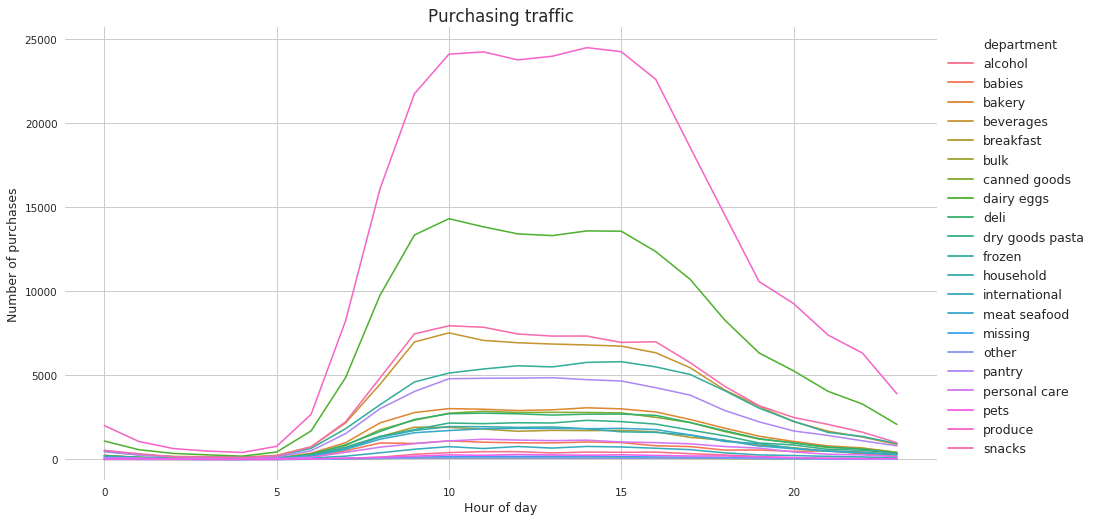

In [53]:
# create plot
sns.set_style('whitegrid')
plt.figure(figsize=(15, 8), dpi=75)

# plot data
sns.lineplot(x='order_hour_of_day', y='number_of_orders',  
             hue='department', linewidth=1.5, data=x3)

# set legend outside the plot             
plt.legend(bbox_to_anchor=(1, 1), loc=2, fontsize=12)
plt.title('Purchasing traffic', fontsize=16)
plt.xlabel('Hour of day', fontsize=12)
plt.ylabel('Number of purchases', fontsize=12)

The majority of purchasing traffic occurs between 10am and 3pm. To beat the shopping crowd, it is best to do it before 10am when items are still widely available, or after 3pm (but risk some items being out of stock). There are also items from departments that don't really have a defined pattern. For these departments (i.e. alcohol, which is closer to the bottom of the x-axis), the number of products purchased remains constant throughout the day. This tells us that purchasing traffic is not uniform for all departments, which makes sense because not all customers shop each department with the same frequency.

This plot provides an aggregate view of when items from each department are purchased, which may mask some of the underlying structure. I suspect if we peel back some more layers, and get more specific (i.e. compare when beer and milk are purchased), other time-dependent patterns may exist.